In [48]:
import numpy as np 
import pandas as pd 
import gc
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import log_loss, matthews_corrcoef
from sklearn.model_selection import StratifiedKFold
from plotnine import *

In [2]:
dir = 'data/'
out = 'mid_output/'
train_numeric = dir + 'train_numeric.csv'
train_cate = dir + 'train_categorical.csv'
test_cate = dir + 'test_categorical.csv'

## Feature importance

In [21]:
train_1 = pd.read_csv(out + 'cate_train_xgb_1-400(15).csv', index_col=0)
train_2 = pd.read_csv(out + 'cate_train_xgb_2-400(16).csv', index_col=0)
train_3 = pd.read_csv(out + 'cate_train_xgb_3-400(15).csv', index_col=0)
train_4 = pd.read_csv(out + 'cate_train_xgb_4-400(15).csv', index_col=0)
train_5 = pd.read_csv(out + 'cate_train_xgb_5-540(20).csv', index_col=0)

In [22]:
train_12 = pd.merge(train_1, train_2, how = 'left', on = 'Id')
train_123 = pd.merge(train_12, train_3, how = 'left', on = 'Id')
train_1234 = pd.merge(train_123, train_4, how = 'left', on = 'Id')
train_12345 = pd.merge(train_1234, train_5, how = 'left', on = 'Id')
cate_train = train_12345.copy()
del train_12, train_123, train_1234, train_12345, train_1, train_2, train_3, train_4, train_5
gc.collect()

90

In [15]:
feats = list(cate_train.columns)
cate_train = pd.read_csv(train_cate, usecols = feats)
col = list(set(cate_train.columns) - set('Id'))

c:\py_venv\tutorial-venv\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (6,8,12,14,43,44,57,59,62,63,74,77,96,98,104,324,335,337,340,342,346,351,354,387,402,406,407,408,464,467,576,588,590,597,610,613,668,671,674,780,807,809,811,842,843,844,845,847,850,900,983,984,1054,1126,1183,1233,1288,1298,1300,1419,1429,1479,1527,1530,1539,1551,1553,1555,1557,1587,1602,1604,1606,1608,1640,1693,1985,1987,1996,1999,2002,2076,2088,2126,2128,2131) have mixed types.Specify dtype option on import or set low_memory=False.


In [16]:
# label encoding
for i in col:
    le = LabelEncoder()
    le.fit(cate_train[i].fillna('NA'))

    cate_train[i] = le.transform(cate_train[i].fillna('NA'))


In [60]:
# one hot encoding
# print(cate_train.shape)
# cate_dum = pd.get_dummies(cate_train.drop(['Id'], axis = 1))
# oh_cate_train = pd.DataFrame(cate_dum)
# oh_cate_train = pd.concat([cate_train.iloc[:, 0], oh_cate_train], axis = 1)
# print(oh_cate_train.shape)

(1183747, 91)
(1183747, 350)


In [27]:
feat_selected = pd.read_csv(out + 'cate_train_feature_factor_selected.csv', index_col=0)
cate_train = pd.merge(cate_train, feat_selected, how = 'left', on = 'Id')

In [28]:
print(cate_train.shape)
response = pd.read_csv(train_numeric, usecols = ['Id', 'Response'])
data = pd.merge(cate_train, response, how = 'left', on = 'Id')
print(data.shape)

(1183747, 99)
(1183747, 100)


In [9]:
np.random.seed(10)
data = data.sample(frac = 1.0)
gc.collect()

21

In [29]:
X = data.drop(['Id', 'Response'], axis = 1)
y = data['Response']
print(X.shape)
print(y.shape)

(1183747, 98)
(1183747,)


In [31]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123)
scores = []
for tr_idx, va_idx in kf.split(X, y):
    tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
    tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]

    dtrain = xgb.DMatrix(tr_x, label = tr_y)
    dvalid = xgb.DMatrix(va_x, label = va_y)

    num_round = 100
    params = {'colsample_bytree':0.8, 
              'eta':0.1,
              'max_depth': 7,
              'subsample': 0.8,
              'eval_metric': 'logloss',
              'objective': 'binary:logistic',
              'random_state': 71,
              'silent': 0
            }

    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

    model = xgb.train(params, dtrain, num_round, evals = watchlist, early_stopping_rounds = 10)
    va_pred = model.predict(dvalid)
    score = log_loss(va_y, va_pred)
    print('logss value: {}'.format(score))
    scores.append(score)
    del va_pred, score
    gc.collect()

print('avg_logloss:', np.mean(scores))

# model.save_model("cate_xgb_model-5.json")

[21:19:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.59994	eval-logloss:0.60018
[1]	train-logloss:0.52482	eval-logloss:0.52411
[2]	train-logloss:0.46051	eval-logloss:0.46078
[3]	train-logloss:0.40700	eval-logloss:0.40741
[4]	train-logloss:0.36125	eval-logloss:0.36176
[5]	train-logloss:0.32253	eval-logloss:0.32251
[6]	train-logloss:0.28825	eval-logloss:0.28837
[7]	train-logloss:0.25909	eval-logloss:0.25885
[8]	train-logloss:0.23305	eval-logloss:0.23306
[9]	train-logloss:0.21030	eval-logloss:0.21032
[10]	train-logloss:0.19010	eval-logloss:0.19024
[11]	train-logloss:0.17258	eval-logloss:0.17264
[12]	train-logloss:

In [32]:
# model = xgb.Booster()
# model.load_model("cate_xgb_model-1.json")
fscore = model.get_score(importance_type = 'total_gain')

keys = list(fscore.keys())
values = list(fscore.values())
feat_imp = pd.DataFrame({'feature': keys, 'scores': values}, index=keys).sort_values(by = "scores", ascending=True)
feat_imp['feature'] = pd.Categorical(
feat_imp.feature, categories=pd.unique(feat_imp.feature))
feat_imp['score'] = feat_imp['scores'].transform(lambda x: (x/float(x.sum())*100))
feat_imp

,feature,scores,score
L0_S9_F184,L0_S9_F184,0.190186,0.001095
L0_S9_F179,L0_S9_F179,0.265625,0.001529
L1_S24_F1286,L1_S24_F1286,0.591354,0.003404
L1_S24_F1593,L1_S24_F1593,0.617690,0.003556
L0_S9_F151,L0_S9_F151,0.712935,0.004104
...,...,...,...
L1_S24_F1523,L1_S24_F1523,437.591766,2.519240
others,others,539.554138,3.106243
T1,T1,581.834717,3.349654
L3_S32_F3851,L3_S32_F3851,1270.810913,7.316128


c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plotnine-save-9223371851864998604.svg


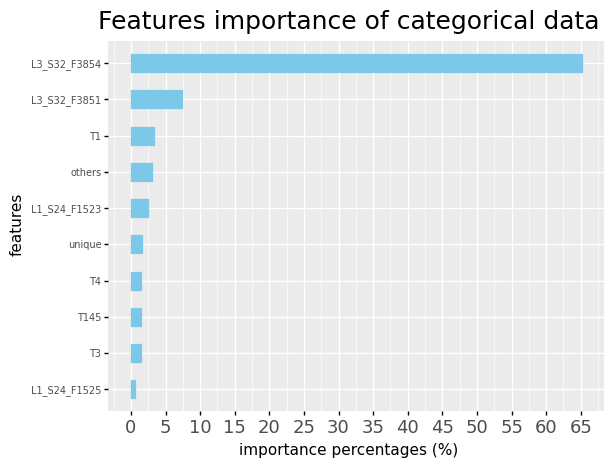

<ggplot: (-9223371851864998604)>

In [93]:
g = (
    ggplot(feat_imp.iloc[-10:, :])
    + geom_bar(aes(x = 'feature', y = 'score'), stat = "identity", color='#7cc8e9', fill='#7cc8e9', width = 0.5)
    + theme(axis_text_x = element_text(angle = 0, size = 13),
            axis_text_y=element_text(size=7),
            plot_title=element_text(size=18))
    + scale_y_continuous(breaks = range(0, 100, 5))
    + coord_flip()
    + labs(x = 'features',y = 'importance percentages (%)')
    + ggtitle('Features importance of categorical data')
)
# ggsave(file="Features importance of numeric data.svg", plot = g, width = 10, height = 8, dpi = 500, format = 'svg')
g

In [44]:
# select top k importance features
original_features = list(feat_imp.iloc[-15:, 0])
original_features = list(set(original_features) - set(['T3', 'unique', 'T1', 'others', 'T4', 'T145']))
factor_features = ['Id', 'T3', 'unique', 'T1', 'others', 'T4', 'T145']

In [59]:
# original_features.append('Id')
cate_train = pd.read_csv(train_cate, usecols = original_features)
cate_test = pd.read_csv(test_cate, usecols = original_features)

c:\py_venv\tutorial-venv\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (809,811,842,844,1551,1587,1985,1987,1996) have mixed types.Specify dtype option on import or set low_memory=False.
c:\py_venv\tutorial-venv\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (809,811,842,844,1985,1987,1996) have mixed types.Specify dtype option on import or set low_memory=False.


In [64]:
col = list(set(original_features) - set(['Id']))
for i in col:
    le = LabelEncoder()
    le.fit(cate_train[i].fillna('NA'))

    cate_test[i] = cate_test[i].fillna('NA')
    cate_test[i] = cate_test[i].map(lambda s: -1 if s not in le.classes_ else s)
    le.classes_ = np.append(le.classes_, - 1)

    cate_train[i] = le.transform(cate_train[i].fillna('NA'))
    cate_test[i] = le.transform(cate_test[i])


In [65]:
train_factor = pd.read_csv(out + 'cate_train_feature_factor_selected.csv', usecols = factor_features)
test_factor = pd.read_csv(out + 'cate_test_feature_factor_selected.csv', usecols = factor_features)
cate_train = pd.merge(cate_train, train_factor, how = 'left', on = 'Id')
cate_test = pd.merge(cate_test, test_factor, how = 'left', on = 'Id')

In [73]:
# cate_train.to_csv(out + 'cate_train_features.csv')
# cate_test.to_csv(out + 'cate_test_features.csv')

# Analysis important feature

In [42]:
train_cate_ = pd.read_csv('data/train_categorical.csv', usecols = ['Id', 'L3_S32_F3854'])
response = pd.read_csv(train_numeric, usecols = ['Id', 'Response'])
top_feature = pd.merge(train_cate_, response, how = 'left', on = 'Id')

c:\py_venv\tutorial-venv\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1987) have mixed types.Specify dtype option on import or set low_memory=False.


In [43]:
top_feature = top_feature.dropna(subset = ['L3_S32_F3854'])
propertion = top_feature.groupby('Response')['L3_S32_F3854'].value_counts(normalize=True)\
   .unstack()\
   .mul(100)\
   .round(2)\
   .fillna(0)
propertion

(21582, 3)


L3_S32_F3854,T-2147481664,T-21474819,T-2147482176,T-2147482432,T-21474825,T-2147482688,T-2147482816,T-2147482944,T-2147483648,T-21474872,...,T36992,T4,T48,T492,T512,T55424,T63616,T64,T65536,T8
Response,,,,,,,,,,,,,,,,,,,,,
0,0.17,0.02,0.0,1.81,0.06,1.77,1.87,0.0,3.06,0.56,...,0.19,2.52,2.54,0.02,7.17,0.0,0.01,0.0,0.03,13.53
1,0.00,0.00,0.0,0.37,0.00,0.09,0.18,0.0,0.18,0.00,...,0.00,14.35,3.22,0.00,0.83,0.0,0.00,0.0,0.00,1.38


In [57]:
class_ = ['T2', 'T4']
np.array([1 if value in class_ else 0 for value in top_feature['L3_S32_F3854'].values]).sum()

4808

In [58]:
top_feature['L3_S32_F3854 class'] = np.array([1 if value in class_ else 0 for value in top_feature['L3_S32_F3854'].values])
top_feature['L3_S32_F3854 class'] = top_feature['L3_S32_F3854 class'].astype('category')
top_feature['Response'] = top_feature['Response'].astype('category')



In [61]:
propertion = top_feature.groupby('Response')['L3_S32_F3854 class'].value_counts(normalize=True)\
   .unstack()\
   .mul(100)\
   .round(2)\
   .fillna(0)
good_pro = propertion.iloc[0, 1]
ng_pro = propertion.iloc[1, 1]

c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plotnine-save-9223371901291647968.svg


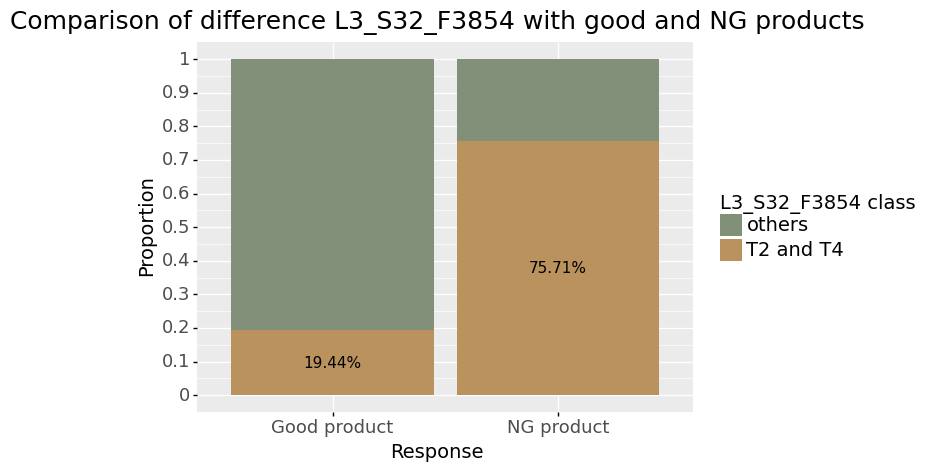

<ggplot: (-9223371901291647968)>

In [66]:
g = (
    ggplot(top_feature, aes(x = 'Response', fill = 'L3_S32_F3854 class'))
    + geom_bar(position = 'fill')
    + scale_y_continuous(breaks = np.linspace(0, 1, 11))
    + scale_x_discrete(labels=["Good product", 'NG product'])
    + theme(axis_text_x=element_text(size=13),
            axis_text_y=element_text(size=13),
            axis_title=element_text(size=14),
            plot_title=element_text(size=18),
            legend_text = element_text(size = 14),
            legend_title = element_text(size = 14)
    )
    + scale_fill_manual(values= ["#829079", "#b9925e"], labels = ['others', 'T2 and T4'])
    + labs(y = 'Proportion')
    + annotate("text", x = 1, y = good_pro/200, label = "{}%".format(good_pro))
    + annotate("text", x = 2, y = ng_pro/200, label = "{}%".format(ng_pro))
    + ggtitle('Comparison of difference {} with good and NG products'.format('L3_S32_F3854'))

)
ggsave(file="Comparison of Id difference with good and NG products.svg", plot = g, width = 10, height = 8, dpi = 500, format = 'svg')

g